
### Package installation and import


In [2]:

!pip install "tensorflow-text==2.8.*"
import numpy as np

import typing
from typing import Any, Tuple
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Data loading

I have uploaded the data in the my colab and read the data from there.

I read the data from source and the target file line by line. newline is the separator for the line. Then seggreagate the words by spearating using the separator whitespace and comma for source and target files respectively.

For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [17]:
def load_data_file():
  source_file = "sentencesTrain.txt"
  target_file = "tokensTrain.txt"

  text_pairs_source = []
  text_pairs_target = []

  source_vocab = []
  target_vocab = []

  max_seq_inp = 0
  max_seq_tar = 0

  with open(source_file,encoding="unicode_escape") as file1, open(target_file,encoding="unicode_escape") as file2:
      for line1, line2 in zip(file1, file2):
          line1 = line1.replace("\n", " ")
          line1 = line1.strip()

          
          
          line2 = line2.replace(",", " ")
          line2 = line2.replace("\n", " ")
          line2 = line2.strip()
          text_pairs_source.append(line1)
          text_pairs_target.append(line2)
          
          # Finding the max sequence
          seq_i = line1.split(" ")
          seq_t = line2.split(" ")

          for word in seq_i:
              source_vocab.append(word)
          for word in seq_t:
              target_vocab.append(word)

          

          if len(seq_i)>max_seq_inp:
              max_seq_inp = len(seq_i)         
            
            
          if len(seq_t)>max_seq_tar:
              max_seq_tar = len(seq_t)


  return text_pairs_target,text_pairs_source,max_seq_inp,max_seq_tar,source_vocab,target_vocab

## Function for counting vocabulary size

In [18]:
def unique(list1):
     
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    counter = 0
    for x in unique_list:
        counter = counter +1
    return counter
      

## Data Analysis



*   Vocabulary Size
*   Maximum Sequence
*   Sample data before tokenization



In [19]:
targ, inp, s_len, t_len, source_vocab,target_vocab = load_data_file()

 

max_vocab_size_source = unique(source_vocab)
max_vocab_size_target = unique(target_vocab)
print("Vocabulary Size for Source: " + str(max_vocab_size_source))
print("Vocabulary Size for Target: " + str(max_vocab_size_target))






Vocabulary Size for Source: 1552
Vocabulary Size for Target: 1291


In [20]:
print("Maximum Sequence in Source: "+ str(s_len))
print("Maximum Sequence in Target: "+ str(t_len))

Maximum Sequence in Source: 29
Maximum Sequence in Target: 40


In [22]:
import random
for i in range(5):
    print("Source " + str(i) + ":" + random.choice(inp))
    print("Target " + str(i) + ":" + random.choice(targ))
    print("----------------------------------------------")



Source 0:What is my aunt an expert at making?
Target 0:(25)WHY FATHER (P)UPSET (1h)part:indef KNOW+(1h)NEG
----------------------------------------------
Source 1:When I meet new people Im lousy at memorizing their names.
Target 1:fs-JOHN IX-3p:i NOT BUY TURKEY (1h)part:indef BUY
----------------------------------------------
Source 2:Why dont you like that video game?
Target 2:IX-2p ARTICLE IX-2p WRITE FOR ns-BOSTON fs-GLOBE IX-1p READ WOW (1h)GOOD/THANK-YOU IX-3p:i ARTICLE WRITE READ
----------------------------------------------
Source 3:I just drank it and it tastes fine.
Target 3:HEAR/LISTEN TEACH+AGENT WHO TEACH AGENT
----------------------------------------------
Source 4:Are Jen and Joe married?
Target 4:IX-2p GO WHERE (1h)part:indef GO
----------------------------------------------


### Create a tensorflow dataset

In [23]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

### Data after converting to tensorflow

In [25]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Once my friends start dying their hair, many more people will follow.'
 b'Who bought the car?'
 b"No, it won't rain, but if it does the game will be cancelled for sure."
 b'My pay increased a little bit.'
 b'Each student that received an award is here watching.'], shape=(5,), dtype=string)

tf.Tensor(
[b'#WHEN POSS-1p FRIEND START HAIR_2+DYE etcetera GUARANTEE MANY PEOPLE FUTURE FOLLOW FRIEND START HAIR_2 DYE etcetera GUARANTEE MANY PEOPLE FOLLOW'
 b'WHO BUY CAR part:indef BUY CAR part:indef'
 b'wave no REFUSE RAIN you see #IF+ RAIN you know GAME+ FOR REALLY CANCEL/CRITICIZE RAIN you see RAIN you know GAME+ CANCEL/CRITICIZE'
 b'POSS-1p PAY IX-1p INCREASE LITTLE-BIT SMALL-AMOUNT INCREASE part:indef PAY INCREASE part:indef'
 b'EACH STUDENT WHO GET TROPHY IX-3p:i HERE (2h)LOOK-UP EACH STUDENT GET TROPHY HERE (2h)LOOK-UP'], shape=(5,), dtype=string)


#### Data preprocessing

In [ ]:
example_text = tf.constant('When does the party start, at 8 or 9?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

**Source data preprocessing**

Built in library is used

1.   Unicode normalization
2.   Replcae unwanted characters
3.   Add start and end token



In [26]:
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ 0-9 a-z.?!,¿]', '')
  
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

**Target data preprocessing**

Built in library is used
1.   Add start and end token

Since I am not aware of the sign language, I did not make any modification to the target data.

In [27]:
def tf_normalize_tex(text):

  
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

#### Text Vectorization

I used built in function to vectorize the data for both source and the target.

In [28]:
max_vocab_size = 500

In [29]:
input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size_source)

Sample source data after vectorization

In [30]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'i', 'to', '?']

Sample target data after vectorization

In [42]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_normalize_tex,
    #standardize = tf_lower_and_split_punct,
    max_tokens=max_vocab_size_target)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary(targ)[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'IX-1p',
 'FRIEND',
 'IX-3p:i',
 'part:indef',
 'IX-loc:i',
 '(1h)part:indef']

Convert the strings into token ID

In [43]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  2, 373,  10,  30,  71, 980,  74, 397,   6, 160],
       [  2,  18, 138,   5,  60,   9,   3,   0,   0,   0],
       [  2,  21,   6,  16, 128, 206,   6,  94,  11,  16]])>

Convert token ID to original word

In [44]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] once my friends start dying their hair , many more people will follow . [END]          '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

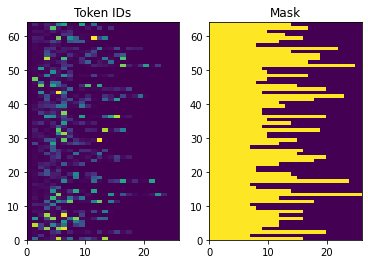

In [45]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

Define the hyperparameters

In [89]:
embedding_dim = 256
units = 1024


In [47]:
use_builtins = True

class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

### The encoder



In [48]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [49]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 26)
Encoder output, shape (batch, s, units): (64, 26, 1024)
Encoder state, shape (batch, units): (64, 1024)


### The attention head

In [51]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### Test the Attention layer

Create a `BahdanauAttention` layer:

In [60]:
attention_layer = BahdanauAttention(units)

This layer takes 3 inputs:

* The query This will be generated by the decoder, later.
* The value: This Will be the output of the encoder.
* The mask: To exclude the padding, example_tokens != 0

In [58]:
(example_tokens != 0).shape

TensorShape([64, 26])

In [61]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 26)


The attention weights must sum to `1.0` for each sequence.

In [62]:
attention_weights.shape

TensorShape([64, 2, 26])

In [63]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [ ]:
#@title
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### The decoder



In [64]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [65]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Here is the implementation of the call method:

In [66]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [67]:
Decoder.call = call

In [68]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

The decoder takes 4 inputs (new_tokens, enc_output, mask, state).


In [69]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [70]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 1291)
state shape: (batch_size, dec_units) (64, 1024)


In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

## Training



### Define the loss function

In [71]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [72]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [73]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [74]:
TrainTranslator._preprocess = _preprocess

In [75]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [76]:
TrainTranslator._train_step = _train_step

In [77]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [78]:
TrainTranslator._loop_step = _loop_step

### Test the training step



In [79]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [80]:
np.log(output_text_processor.vocabulary_size())

7.1631723908466425

In [81]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [82]:
TrainTranslator._tf_train_step = _tf_train_step

In [83]:
translator.use_tf_function = True

In [ ]:
translator.train_step([example_input_batch, example_target_batch])

### Create the model using encoder, attention, and decoder
I use "Adam" as optimizer

In [85]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

I use a callbacks.Callback to collect the history of batch losses, for plotting.

In [86]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

Define the number of epochs

In [90]:
num_epoch = 40

In [91]:
train_translator.fit(dataset, epochs=num_epoch,
                     callbacks=[batch_loss])

Epoch 1/40
11/11 [==============================] - 13s 1s/step - batch_loss: 3.6649
Epoch 2/40
11/11 [==============================] - 10s 916ms/step - batch_loss: 3.3462
Epoch 3/40
11/11 [==============================] - 10s 903ms/step - batch_loss: 3.0367
Epoch 4/40
11/11 [==============================] - 10s 931ms/step - batch_loss: 2.7174
Epoch 5/40
11/11 [==============================] - 10s 914ms/step - batch_loss: 2.4467
Epoch 6/40
11/11 [==============================] - 10s 924ms/step - batch_loss: 2.1591
Epoch 7/40
11/11 [==============================] - 10s 921ms/step - batch_loss: 1.9167
Epoch 8/40
11/11 [==============================] - 10s 906ms/step - batch_loss: 1.7022
Epoch 9/40
11/11 [==============================] - 10s 941ms/step - batch_loss: 1.4866
Epoch 10/40
11/11 [==============================] - 10s 922ms/step - batch_loss: 1.2899
Epoch 11/40
11/11 [==============================] - 10s 914ms/step - batch_loss: 1.0912
Epoch 12/40
11/11 [==============

Text(0, 0.5, 'CE/token')

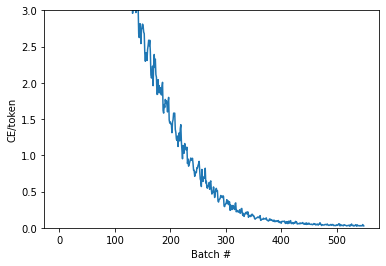

In [92]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

There is a fluctuation in the between the batches of the epochs initially and then it smoothly converges.

In [93]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [94]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Convert token IDs to text

In [95]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [96]:
Translator.tokens_to_text = tokens_to_text

Input some random token IDs and see what it generates:

### Sample from the decoder's predictions

In [98]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [99]:
Translator.sample = sample

Test run this function on some random inputs:

In [100]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 421],
       [1201],
       [ 930],
       [ 104],
       [ 712]])>

### Translation

*   Prediction is stored in list
*   Then it is converted to tensors




In [101]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [102]:
Translator.translate = translate_unrolled

### Check the translation from the training data

In [103]:
%%time

input_text = tf.constant([
    'If mom has time she will bring cookies.', # "MOTHER,IX-loc:i,#IF+,(1h)HAVE,TIME+,IX-3p:i,FUTURE,BRING,COOKIE,TIME+,BRING,COOKIE"
    "I just drank it and it tastes fine.", # "IX-1p,RECENT-PAST,DRINK,TASTE,FINE++,(1h)part:indef"
    "My friend goes out to a party.", # "FRIEND,GO-OUT,(P)PARTY,FRIEND,(P)PARTY"
])



result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print(result['text'][2].numpy().decode())


#IF POSS-1p FRIEND IX-3p:i FINISH BRING COOKIE GUARANTEE BRING COOKIE
IX-1p RECENT-PAST DRINK TASTE FINE++ (1h)part:indef
FRIEND IX-3p:i GO-OUT (P)PARTY+ FRIEND DRIVE
CPU times: user 517 ms, sys: 13.3 ms, total: 530 ms
Wall time: 528 ms


### Output the predicted tokens from the test data in a comma sepearted txt files.

*   Collected the predicted result for each line
*   Replace the whitespace with comma
*   Finally write the text to file by line 




In [104]:
version = "v4"
test_file = "sentencesTest.txt"

outputfile = "submission_islam_"+version+".txt"
out = open(outputfile, "w")

with open(test_file,encoding="unicode_escape" ) as f:
    lines_test = f.read().split("\n")[:-1]

for input_sentence in lines_test:
    
    list_data = []
    list_data.append(input_sentence)
    input_text = tf.constant(list_data)
    result = translator.translate(input_text = input_text)

    
    translated = result['text'][0].numpy().decode()
    translated = translated.replace(" ", ",")
    
    
    out.write(translated+'\n')

out.close()

**Reference:**

* https://www.tensorflow.org/text/tutorials/nmt_with_attention

I have used this model which was used to create translation from English to Spanish.
